Import libraries

In [9]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Import dataset

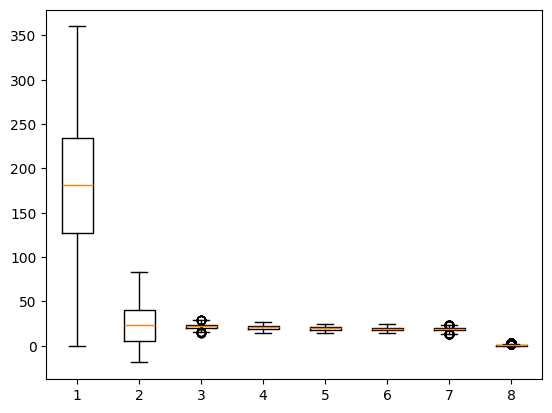

              alpha         delta             u             g             r  \
count  97814.000000  97814.000000  97814.000000  97814.000000  97814.000000   
mean     177.599567     24.150785     22.071659     20.630475     19.636028   
std       96.535545     19.654619      2.239830      2.023809      1.834898   
min        0.005528    -18.785328     14.311050     14.520380     14.168760   
25%      127.478240      5.144758     20.332845     18.938333     18.100860   
50%      180.868223     23.685853     22.157445     21.092910     20.105900   
75%      233.890810     39.908920     23.670853     22.131880     21.031697   
max      359.999810     83.000519     29.234380     26.714980     25.121300   

                  i             z      redshift  
count  97814.000000  97814.000000  97814.000000  
mean      19.065337     18.747675      0.521963  
std        1.728697      1.737013      0.595197  
min       13.899870     13.559570     -0.009971  
25%       17.699045     17.430633     

In [2]:
df = pd.read_csv('preprocessed_data.csv',index_col=0)
X = df.drop(columns=['class'])
Y = df['class']
plt.boxplot(X)
plt.show()
print(df.describe())

Discretization

In [3]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

dc.fit(X[['alpha']])
X['alpha']= dc.transform(X[['alpha']])

dc.fit(X[['delta']])
X['delta']= dc.transform(X[['delta']])

dc.fit(X[['u']])
X['u']= dc.transform(X[['u']])

dc.fit(X[['g']])
X['g']= dc.transform(X[['g']])

dc.fit(X[['r']])
X['r']= dc.transform(X[['r']])

dc.fit(X[['i']])
X['i']= dc.transform(X[['i']])

dc.fit(X[['z']])
X['z']= dc.transform(X[['z']])

dc.fit(X[['redshift']])
X['redshift']= dc.transform(X[['redshift']])

print(X.head())

   alpha  delta    u    g    r    i    z  redshift
0    3.0    5.0  7.0  7.0  5.0  5.0  5.0       3.0
1    3.0    5.0  8.0  7.0  9.0  8.0  8.0       4.0
2    3.0    5.0  8.0  7.0  6.0  5.0  5.0       3.0
3    8.0    1.0  5.0  8.0  7.0  7.0  5.0       4.0
4    9.0    3.0  2.0  1.0  1.0  1.0  1.0       0.0


Set Up Evaluation Parameters

In [4]:
criterion = ['gini', 'entropy','log_loss']
max_depth = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
score = {
    'gini' : [],
    'entropy' : [],
    'log_loss' : []
}
for criteria in criterion:  
    for depth in max_depth:
        clf = tree.DecisionTreeClassifier(criterion=criteria, max_depth=depth)
        score[criteria].append(np.mean(cross_val_score(clf, X, Y, cv=10)))
    
print(score)

{'gini': [np.float64(0.814770914012582), np.float64(0.8803749486479312), np.float64(0.9026315420361822), np.float64(0.9109943271863585), np.float64(0.9154722422274556), np.float64(0.9176701860292648), np.float64(0.9149712312399678), np.float64(0.9132741123844665), np.float64(0.9102786330388106), np.float64(0.9084691097747688), np.float64(0.906618662677052), np.float64(0.9060461637984727), np.float64(0.9060972864514298), np.float64(0.9059745839319662), np.float64(0.9060666116054454)], 'entropy': [np.float64(0.8615638650836891), np.float64(0.8858036354996756), np.float64(0.90619950458279), np.float64(0.9119553291715432), np.float64(0.9177520399676655), np.float64(0.9186925512936959), np.float64(0.9164945040195451), np.float64(0.9135808451666847), np.float64(0.9101355098869286), np.float64(0.9088269234029374), np.float64(0.9073445368307291), np.float64(0.9067515765579), np.float64(0.9069253756009419), np.float64(0.9067720285455734), np.float64(0.9064448584081344)], 'log_loss': [np.float64

Plotting results (Gini)

Text(0.5, 1.0, 'Score vs. Max Depth (Gini Index)')

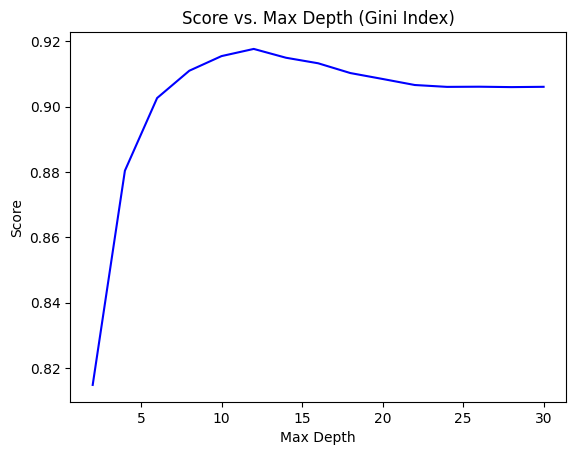

In [5]:
gini = score['gini']
entropy = score['entropy']
log_loss = score['log_loss']

plt.plot(max_depth, gini, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Gini Index)')

Entropy

Text(0.5, 1.0, 'Score vs. Max Depth (Entropy)')

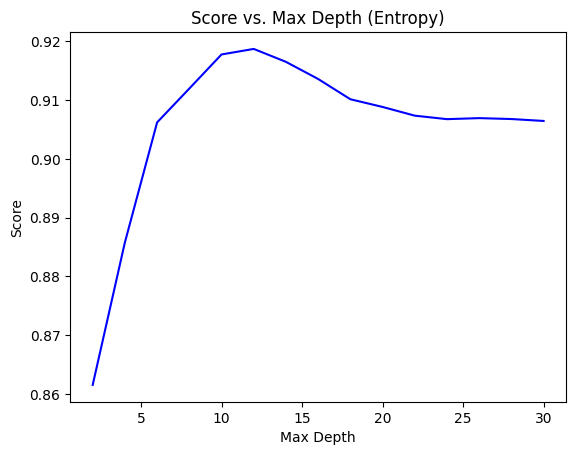

In [6]:
plt.plot(max_depth, entropy, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Entropy)')

Log Loss

Text(0.5, 1.0, 'Score vs. Max Depth (Log Loss)')

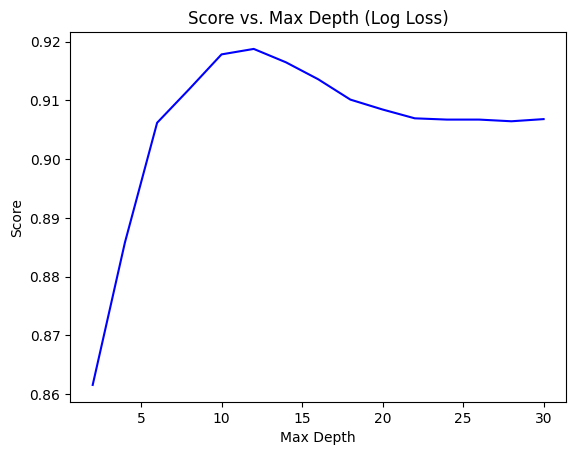

In [7]:
plt.plot(max_depth, log_loss, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Log Loss)')

Final Processing

In [8]:
print("Best Max Depth (Gini): ", (np.argmax(gini)+1)*2)
print("Score: ", max(gini))
print("Best Max Depth (Entropy): ", (np.argmax(entropy)+1)*2)
print("Score: ", max(entropy))
print("Best Max Depth (Log Loss): ", (np.argmax(log_loss)+1)*2)
print("Score: ", max(log_loss))


Best Max Depth (Gini):  12
Score:  0.9176701860292648
Best Max Depth (Entropy):  12
Score:  0.9186925512936959
Best Max Depth (Log Loss):  12
Score:  0.9187743467022873


In [21]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=12)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
clf.fit(x_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=12)

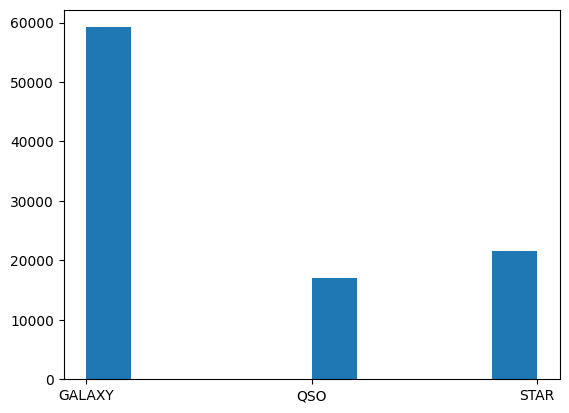

In [38]:
clf.score(x_test, y_test)
plt.hist(df['class'])
plt.show()

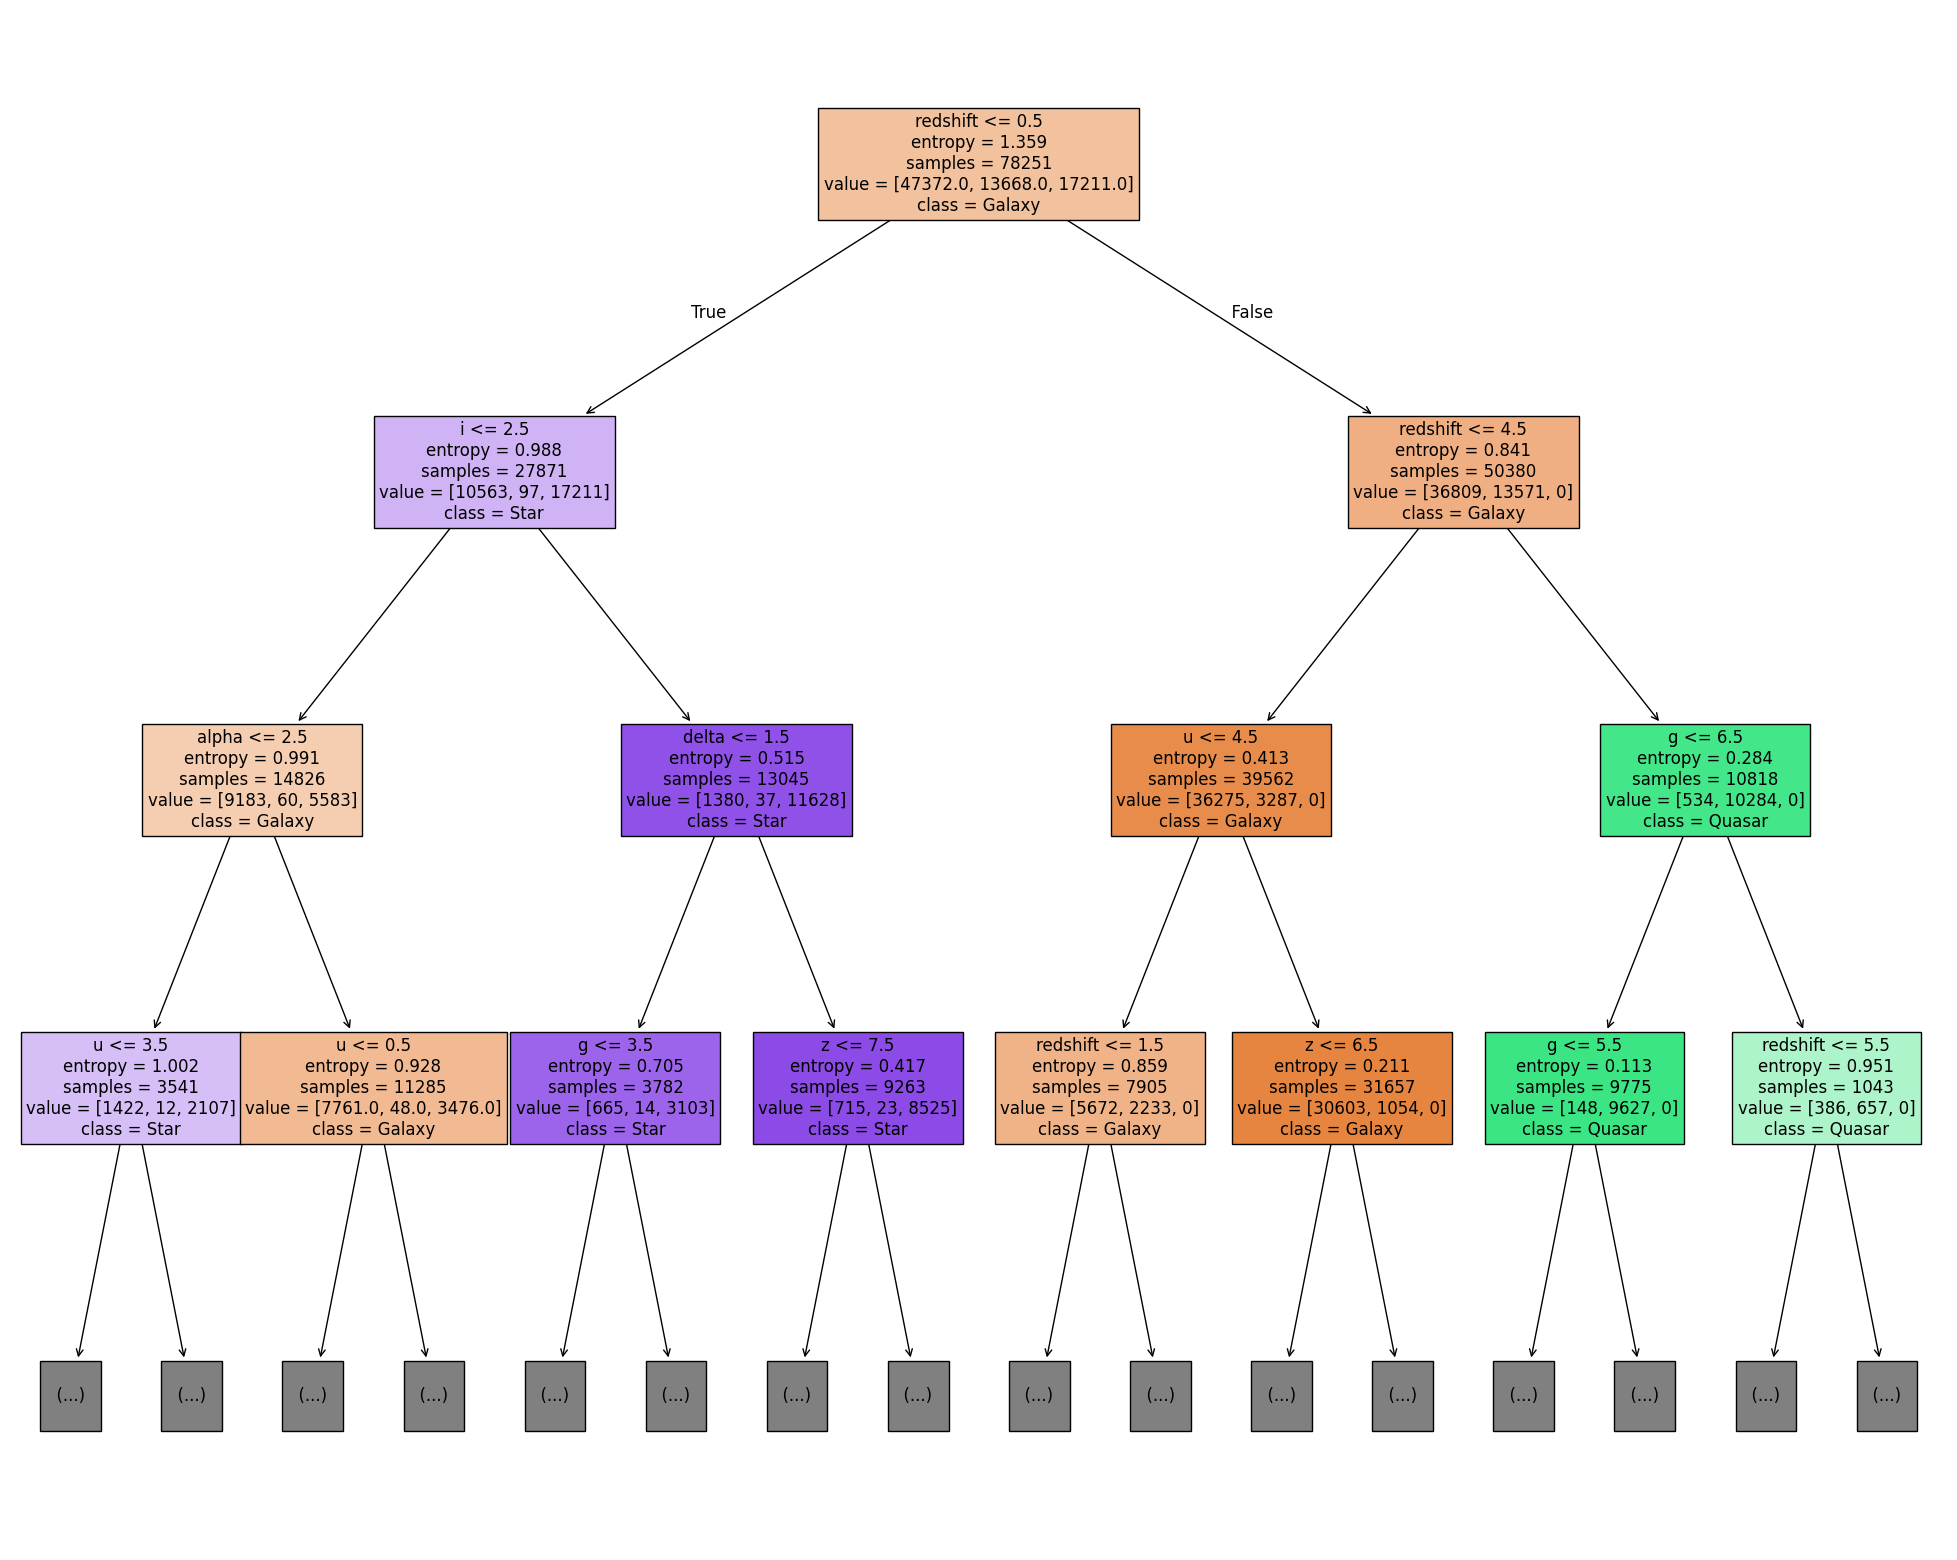

In [40]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                    feature_names=['alpha', 'delta', 'u','g','r','i','z','redshift'],
                    class_names=['Galaxy', 'Quasar', 'Star'],
                    max_depth=3,
                    fontsize=12,
                    filled=True)

In [36]:
print(tree.export_text(clf))

|--- feature_7 <= 0.50
|   |--- feature_5 <= 2.50
|   |   |--- feature_0 <= 2.50
|   |   |   |--- feature_2 <= 3.50
|   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |--- feature_1 <= 8.50
|   |   |   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_5 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: STAR
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: STAR
|  